# Sample Notebook for Zero-Shot Inference with CheXzero
This notebook walks through how to use CheXzero to perform zero-shot inference on a chest x-ray image dataset.

## Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Optional

import sys
sys.path.append('../')

from eval import evaluate, bootstrap
from zero_shot import make, make_true_labels, run_softmax_eval

%load_ext autoreload
%autoreload 2

## Directories and Constants

In [2]:
## Define Zero Shot Labels and Templates

# ----- DIRECTORIES ------ #
cxr_filepath: str = '/home/vault/iwi5/iwi5207h/new/CheXzero/dataset/new_testing_without_lateral.h5' # filepath of chest x-ray images (.h5)
cxr_true_labels_path: Optional[str] = '/home/hpc/iwi5/iwi5207h/Thesis/dataset_csv/testing_data_without_lateral_only_nec.csv' # (optional for evaluation) if labels are provided, provide path
model_dir: str = '../checkpoints/chexzero_weights' # where pretrained models are saved (.pt) 
predictions_dir: Path = Path('../predictions') # where to save predictions
cache_dir: str = predictions_dir / "cached" # where to cache ensembled predictions

context_length: int = 77

# ------- LABELS ------  #
# Define labels to query each image | will return a prediction for each label
cxr_labels: List[str] = ['Lobar Atelectasis','Round(ed) Atelectasis','Clavicle Fracture','Azygos Lobe','Pleural Other','Pneumoperitoneum',
                  'Kyphosis','Hydropneumothorax','Infarction','Pneumomediastinum','Pulmonary Hypertension','Fibrosis']
'''cxr_labels: List[str] = ['Adenopathy', 'Atelectasis', 'Azygos Lobe', 'Calcification of the Aorta', 
                     'Cardiomegaly', 'Clavicle Fracture', 'Consolidation', 'Edema', 'Emphysema', 
                     'Enlarged Cardiomediastinum', 'Fibrosis', 'Fissure', 'Fracture', 'Granuloma', 
                     'Hernia', 'Hydropneumothorax', 'Infarction', 'Infiltration', 'Kyphosis', 
                     'Lobar Atelectasis', 'Lung Lesion', 'Lung Opacity', 'Mass', 'Nodule', 
                     'Normal', 'Pleural Effusion', 'Pleural Other', 'Pleural Thickening', 
                     'Pneumomediastinum', 'Pneumonia', 'Pneumoperitoneum', 'Pneumothorax', 
                     'Pulmonary Embolism', 'Pulmonary Hypertension', 'Rib Fracture', 
                     'Round(ed) Atelectasis', 'Subcutaneous Emphysema', 'Support Devices', 
                     'Tortuous Aorta', 'Tuberculosis']'''
'''cxr_labels: List[str] = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 
                         'Fracture', 'Lung Lesion', 'Lung Opacity', 'Nodule', 'Pleural Effusion', 
                         'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']'''

'''cxr_labels: List[str] = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion','Edema','Consolidation',
                         'Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']'''
# ---- TEMPLATES ----- # 
# Define set of templates | see Figure 1 for more details                        
cxr_pair_template: Tuple[str] = ("{}", "no {}")

# ----- MODEL PATHS ------ #
# If using ensemble, collect all model paths
model_paths = []
for subdir, dirs, files in os.walk(model_dir):
    for file in files:
        full_dir = os.path.join(subdir, file)
        model_paths.append(full_dir)
        
print(model_paths)

['../checkpoints/chexzero_weights/best_64_5e-05_original_22000_0.864.pt']


## Run Inference

In [ ]:
## Run the model on the data set using ensembled models
def ensemble_models(
    model_paths: List[str], 
    cxr_filepath: str, 
    cxr_labels: List[str], 
    cxr_pair_template: Tuple[str], 
    cache_dir: str = None, 
    save_name: str = None,
) -> Tuple[List[np.ndarray], np.ndarray]: 
    """
    Given a list of `model_paths`, ensemble model and return
    predictions. Caches predictions at `cache_dir` if location provided.

    Returns a list of each model's predictions and the averaged
    set of predictions.
    """

    predictions = []
    model_paths = sorted(model_paths) # ensure consistency of 
    for path in model_paths: # for each model
        model_name = Path(path).stem

        # load in model and `torch.DataLoader`
        model, loader = make(
            model_path=path, 
            cxr_filepath=cxr_filepath, 
        ) 
        
        # path to the cached prediction
        if cache_dir is not None:
            if save_name is not None: 
                cache_path = Path(cache_dir) / f"{save_name}_{model_name}.npy"
            else: 
                cache_path = Path(cache_dir) / f"{model_name}.npy"

        # if prediction already cached, don't recompute prediction
        if cache_dir is not None and os.path.exists(cache_path): 
            print("Loading cached prediction for {}".format(model_name))
            y_pred = np.load(cache_path)
        else: # cached prediction not found, compute preds
            print("Inferring model {}".format(path))
            y_pred = run_softmax_eval(model, loader, cxr_labels, cxr_pair_template)
            if cache_dir is not None: 
                Path(cache_dir).mkdir(exist_ok=True, parents=True)
                np.save(file=cache_path, arr=y_pred)
        predictions.append(y_pred)
    
    # compute average predictions
    y_pred_avg = np.mean(predictions, axis=0)
    
    return predictions, y_pred_avg

: 

In [ ]:
predictions, y_pred_avg = ensemble_models(
    model_paths=model_paths, 
    cxr_filepath=cxr_filepath, 
    cxr_labels=cxr_labels, 
    cxr_pair_template=cxr_pair_template, 
    cache_dir=cache_dir,
)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
/home/woody/iwi5/iwi5207h/software/private/conda/envs/lol/lib/python3.8/site-packages/transformers/modeling_utils.py:392: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via th

Inferring model ../checkpoints/chexzero_weights/best_64_5e-05_original_22000_0.864.pt


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1375 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1375 [00:00<?, ?it/s]

: 

In [ ]:
# save averaged preds
pred_name = "chexzero_check_org_rare.npy" # add name of preds
predictions_dir = predictions_dir / pred_name
np.save(file=predictions_dir, arr=y_pred_avg)

In [18]:

predictions = (y_pred_avg > 0.5).astype(int)
print(predictions)

[[1 1 0 ... 0 1 1]
 [0 1 0 ... 0 0 1]
 [0 1 0 ... 1 0 1]
 ...
 [0 0 0 ... 1 1 1]
 [1 0 1 ... 0 0 1]
 [1 0 1 ... 0 0 1]]


In [7]:
# Find the index of "Normal" in cxr_labels
normal_index = cxr_labels.index("Normal")

# Initialize a dictionary to store the count of co-occurrences
co_occurrence_counts = {label: 0 for label in cxr_labels if label != "Normal"}

# Iterate through the predictions array to count co-occurrences
for row in predictions:
    if row[normal_index] == 1:
        for i, value in enumerate(row):
            if value == 1 and i != normal_index:
                co_occurrence_counts[cxr_labels[i]] += 1

# Filter out classes that do not co-occur with "Normal"
co_occurrence_counts = {label: count for label, count in co_occurrence_counts.items() if count > 0}

print("Classes that co-occur with 'Normal' and their counts:")
print(co_occurrence_counts)

ValueError: 'Normal' is not in list

In [ ]:
# Find the index of "Normal" in cxr_labels
normal_index = cxr_labels.index("Support Devices")

# Initialize a dictionary to store the count of co-occurrences
co_occurrence_counts = {label: 0 for label in cxr_labels if label != "Support Devices"}

# Iterate through the predictions array to count co-occurrences
for row in predictions:
    if row[normal_index] == 1:
        for i, value in enumerate(row):
            if value == 1 and i != normal_index:
                co_occurrence_counts[cxr_labels[i]] += 1

# Filter out classes that do not co-occur with "Normal"
co_occurrence_counts = {label: count for label, count in co_occurrence_counts.items() if count > 0}

print("Classes that co-occur with 'Support Devices' and their counts:")
print(co_occurrence_counts)

Classes that co-occur with 'Support Devices' and their counts:
{'Adenopathy': 318, 'Atelectasis': 380, 'Azygos Lobe': 245, 'Calcification of the Aorta': 520, 'Cardiomegaly': 400, 'Clavicle Fracture': 537, 'Consolidation': 499, 'Edema': 314, 'Emphysema': 92, 'Enlarged Cardiomediastinum': 701, 'Fibrosis': 512, 'Fissure': 560, 'Fracture': 408, 'Granuloma': 324, 'Hernia': 52, 'Hydropneumothorax': 383, 'Infarction': 472, 'Infiltration': 601, 'Kyphosis': 326, 'Lobar Atelectasis': 332, 'Lung Lesion': 757, 'Lung Opacity': 709, 'Mass': 294, 'Nodule': 444, 'Normal': 747, 'Pleural Effusion': 365, 'Pleural Other': 424, 'Pleural Thickening': 349, 'Pneumomediastinum': 401, 'Pneumonia': 561, 'Pneumoperitoneum': 542, 'Pneumothorax': 426, 'Pulmonary Embolism': 365, 'Pulmonary Hypertension': 297, 'Rib Fracture': 406, 'Round(ed) Atelectasis': 197, 'Subcutaneous Emphysema': 150, 'Tortuous Aorta': 77, 'Tuberculosis': 526}


In [ ]:
# Identify misclassified samples
misclassified_samples = {}
for label in cxr_labels:
    misclassified_samples[label] = np.where(test_true[:, cxr_labels.index(label)] != (test_pred[:, cxr_labels.index(label)] > 0.5))[0]

print("Misclassified Samples for each label:")
for label, samples in misclassified_samples.items():
    print(f"{label}: {samples}")

Misclassified Samples for each label:
Adenopathy: [   0    6    8    9   10   13   17   26   29   32   34   40   41   42
   43   46   51   54   55   57   58   60   63   64   65   66   69   72
   73   74   75   76   77   78   79   80   82   85   89   98   99  103
  106  107  109  110  117  119  122  125  128  139  145  149  150  153
  154  158  160  161  162  167  168  169  171  174  176  180  182  185
  187  188  193  197  200  201  202  204  205  207  210  212  216  221
  222  223  225  226  227  229  230  233  234  235  236  238  239  242
  243  244  246  247  248  255  256  260  262  268  269  273  276  278
  281  283  284  286  290  292  293  294  295  296  299  300  302  303
  304  306  307  309  310  312  313  316  318  319  322  323  327  328
  329  330  332  333  334  335  336  340  342  345  346  347  350  351
  352  354  355  356  357  358  359  360  361  363  367  368  375  377
  381  385  386  387  388  390  392  393  394  395  399  402  408  414
  415  418  419  424  426  

## (Optional) Evaluate Results
If ground truth labels are available, compute AUC on each pathology to evaluate the performance of the zero-shot model. 

In [3]:
# Load the .npy file into y_pred_avg
y_pred_avg = np.load('/home/vault/iwi5/iwi5207h/not_frozen/CheXzero/predictions/vin_dr_chex_ckeck_new.npy')
cxr_true_labels_path: Optional[str] = '/home/hpc/iwi5/iwi5207h/Thesis/dataset_csv/vin_dx_cxr_test_groundtruth.csv'
cxr_labels: List[str] = ["Aortic enlargement", "Atelectasis", "Cardiomegaly", "Calcification", 
    "Clavicle fracture", "Consolidation", "Edema", "Emphysema", "Enlarged PA", 
    "ILD", "Infiltration", "Lung cavity", 
    "Lung cyst", "Lung Opacity", "Mediastinal shift", "Nodule/Mass", 
    "Pulmonary fibrosis", "Pneumothorax", "Pleural thickening", 
    "Pleural effusion", "Rib fracture", "Other lesion", "Lung tumor", 
    "Pneumonia", "Tuberculosis", "Other disease", 
    "COPD", "No finding"]

In [4]:
# make test_true
test_pred = y_pred_avg
test_true = make_true_labels(cxr_true_labels_path=cxr_true_labels_path, cxr_labels=cxr_labels)

# evaluate model
cxr_results = evaluate(test_pred, test_true, cxr_labels)

# boostrap evaluations for 95% confidence intervals
bootstrap_results = bootstrap(test_pred, test_true, cxr_labels)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
# display AUC with confidence intervals
bootstrap_results[1]

,Aortic enlargement_auc,Atelectasis_auc,Cardiomegaly_auc,Calcification_auc,Clavicle fracture_auc,Consolidation_auc,Edema_auc,Emphysema_auc,Enlarged PA_auc,ILD_auc,...,Pleural thickening_auc,Pleural effusion_auc,Rib fracture_auc,Other lesion_auc,Lung tumor_auc,Pneumonia_auc,Tuberculosis_auc,Other disease_auc,COPD_auc,No finding_auc
mean,0.5107,0.5541,0.4898,0.4816,0.4703,0.4733,NaN,0.6696,0.4756,0.5033,...,0.5301,0.4913,0.4832,0.4729,0.5414,0.4691,0.4928,0.4858,0.5390,0.5107
lower,0.4712,0.4919,0.4550,0.4390,0.3975,0.4149,NaN,0.5707,0.2999,0.4622,...,0.4813,0.4412,0.2604,0.4078,0.4814,0.4328,0.4477,0.4590,0.2891,0.4872
upper,0.5500,0.6140,0.5234,0.5240,NaN,0.5355,NaN,NaN,0.6651,0.5433,...,0.5764,0.5438,0.7035,0.5361,0.6003,0.5081,0.5389,0.5116,NaN,0.5332


In [7]:
cxr_results.mean()

Aortic enlargement_auc    0.511264
Atelectasis_auc           0.553533
Cardiomegaly_auc          0.490305
Calcification_auc         0.480948
Clavicle fracture_auc     0.470147
Consolidation_auc         0.476015
Edema_auc                      NaN
Emphysema_auc             0.671560
Enlarged PA_auc           0.472426
ILD_auc                   0.503921
Infiltration_auc          0.522065
Lung cavity_auc           0.578216
Lung cyst_auc             0.721481
Lung Opacity_auc          0.484678
Mediastinal shift_auc     0.435923
Nodule/Mass_auc           0.513698
Pulmonary fibrosis_auc    0.488931
Pneumothorax_auc          0.432484
Pleural thickening_auc    0.529874
Pleural effusion_auc      0.491420
Rib fracture_auc          0.480854
Other lesion_auc          0.470547
Lung tumor_auc            0.541378
Pneumonia_auc             0.470379
Tuberculosis_auc          0.492173
Other disease_auc         0.486176
COPD_auc                  0.535190
No finding_auc            0.510343
dtype: float64

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import math

def find_optimal_thresholds(test_pred, test_true, cxr_labels):
    """
    Calculate the optimal threshold for each label based on F1 score.
    
    Args:
        test_pred (ndarray): The predicted probabilities (N x C, where N is number of samples, C is number of labels).
        test_true (ndarray): The true labels (N x C, same shape as test_pred).
        cxr_labels (list): List of label names.
    
    Returns:
        optimal_thresholds (list): List of optimal thresholds for each label.
        metrics_per_label (list): List of dictionaries containing metrics (f1, precision, recall) for each label.
    """
    optimal_thresholds = []
    metrics_per_label = []
    
    for i, label in enumerate(cxr_labels):
        best_threshold = 0.0
        best_metrics = {'f1': 0.0, 'precision': 0.0, 'recall': 0.0}
        
        # Try all thresholds from 0.0 to 1.0 (with step size of 0.01)
        for threshold in np.arange(0.0, 1.01, 0.01):
            binarized_pred = (test_pred[:, i] >= threshold).astype(int)
            
            # Calculate metrics
            f1 = f1_score(test_true[:, i], binarized_pred)
            precision = precision_score(test_true[:, i], binarized_pred)
            recall = recall_score(test_true[:, i], binarized_pred)
            
            # Optimize for F1 score
            if f1 > best_metrics['f1']:
                best_metrics = {
                    'f1': f1,
                    'precision': precision,
                    'recall': recall,
                    'threshold': threshold
                }
                best_threshold = threshold
        
        # Append the best threshold and corresponding metrics for the label
        optimal_thresholds.append(best_threshold)
        metrics_per_label.append(best_metrics)
        
        # Print the optimal metrics for this label
        '''print(f"\nOptimal metrics for {label}:")
        print(f"Threshold: {best_threshold:.3f}")
        print(f"F1-Score: {best_metrics['f1']:.3f}")
        print(f"Precision: {best_metrics['precision']:.3f}")
        print(f"Recall: {best_metrics['recall']:.3f}")'''
    
    return optimal_thresholds, metrics_per_label


def apply_optimal_thresholds(test_pred, optimal_thresholds):
    """
    Apply the optimal thresholds to the predicted probabilities to binarize the predictions.
    
    Args:
        test_pred (ndarray): The predicted probabilities (N x C).
        optimal_thresholds (list): The list of optimal thresholds for each label.
    
    Returns:
        binarized_pred (ndarray): Binarized predictions based on the optimal thresholds.
    """
    binarized_pred = np.zeros_like(test_pred)
    
    for i, threshold in enumerate(optimal_thresholds):
        binarized_pred[:, i] = (test_pred[:, i] >= threshold).astype(int)
    
    return binarized_pred


def plot_simplified_confusion_matrices(test_pred, test_true, cxr_labels, figsize=(40, 30)):
    """
    Create a simplified and very clear visualization of confusion matrices.
    """
    # Apply the optimal thresholds to binarize predictions
    optimal_thresholds, _ = find_optimal_thresholds(test_pred, test_true, cxr_labels)
    binarized_pred = apply_optimal_thresholds(test_pred, optimal_thresholds)
    
    # Setup plot
    n_labels = len(cxr_labels)
    n_cols = 4  # Set to 4 columns for better horizontal space usage
    n_rows = math.ceil(n_labels / n_cols)
    
    fig = plt.figure(figsize=figsize)
    fig.suptitle('Chest X-Ray Condition Detection Results', fontsize=24, y=0.95, fontweight='bold')
    
    # Increase spacing between subplots
    plt.subplots_adjust(hspace=0.6, wspace=0.6)  # Increase wspace to create more horizontal space
    
    # Define a simpler color palette
    colors = ['#f7fbff', '#2171b5']  # Light to dark blue
    
    for idx, label in enumerate(cxr_labels):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        # Calculate confusion matrix
        cm = confusion_matrix(test_true[:, idx], binarized_pred[:, idx])
        
        # Calculate metrics
        f1 = f1_score(test_true[:, idx], binarized_pred[:, idx])
        precision = precision_score(test_true[:, idx], binarized_pred[:, idx])
        recall = recall_score(test_true[:, idx], binarized_pred[:, idx])
        
        # Create simplified heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=["Normal", "Condition"],
                   yticklabels=["Normal", "Condition"],
                   annot_kws={"size": 16, "weight": "bold"},
                   cbar=False,
                   square=True,
                   ax=ax)
        
        # Add percentages with better formatting
        total = cm.sum()
        for i in range(2):
            for j in range(2):
                percentage = (cm[i, j] / total) * 100
                ax.text(j + 0.5, i + 0.5, f'\n\n({percentage:.1f}%)',
                       ha='center', va='center',
                       color='black' if percentage < 50 else 'white',
                       fontsize=12)
        
        # Simplified title and metrics
        ax.set_title(f'{label}\n', fontsize=16, fontweight='bold', pad=20)
        
        # Add metrics below each plot, centered and adjusted position
        ax.text(0.5, -0.35, 
                f'Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1-Score: {f1:.2f}',
                ha='center', va='center', transform=ax.transAxes,
                fontsize=12, fontweight='bold')
        
        # Better axis labels
        ax.set_xlabel('Predicted', fontsize=14, labelpad=10)
        ax.set_ylabel('Actual', fontsize=14, labelpad=10)
        
        # Add borders to each subplot
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)
            spine.set_color('black')
            
        # Increase tick label size
        ax.tick_params(labelsize=10)
        
    # Remove empty subplots if any
    for idx in range(len(cxr_labels), n_rows * n_cols):
        fig.delaxes(plt.subplot(n_rows, n_cols, idx + 1))
    
    return fig


def print_detailed_summary(test_pred, test_true, cxr_labels):
    """Print a detailed performance summary"""
    # Apply the optimal thresholds to binarize predictions
    optimal_thresholds, _ = find_optimal_thresholds(test_pred, test_true, cxr_labels)
    binarized_pred = apply_optimal_thresholds(test_pred, optimal_thresholds)
    
    print("\n=== CHEST X-RAY CONDITION DETECTION SUMMARY ===")
    print("=" * 65)
    print(f"{'Condition':<20} {'F1-Score':<12} {'Precision':<12} {'Recall':<12}")
    print("-" * 65)
    
    for idx, label in enumerate(cxr_labels):
        f1 = f1_score(test_true[:, idx], binarized_pred[:, idx])
        precision = precision_score(test_true[:, idx], binarized_pred[:, idx])
        recall = recall_score(test_true[:, idx], binarized_pred[:, idx])
        
        # Add highlighting for good/poor performance
        if f1 >= 0.7:
            status = "✓"
        elif f1 <= 0.3:
            status = "!"
        else:
            status = " "
            
        print(f"{label:<19}{status} {f1:^11.3f} {precision:^11.3f} {recall:^11.3f}")
    
    print("-" * 65)
    print("✓ = Good performance (F1 ≥ 0.7)")
    print("! = Needs improvement (F1 ≤ 0.3)")



=== CHEST X-RAY CONDITION DETECTION SUMMARY ===
Condition            F1-Score     Precision    Recall      
-----------------------------------------------------------------
Aortic enlargement !    0.138       0.075       0.950   
Atelectasis        !    0.069       0.039       0.302   
Cardiomegaly       !    0.187       0.103       1.000   
Calcification      !    0.121       0.065       1.000   
Clavicle fracture  !    0.001       0.001       1.000   
Consolidation      !    0.062       0.032       1.000   
Edema              !    0.000       0.000       0.000   
Emphysema          !    0.002       0.001       1.000   
Enlarged PA        !    0.005       0.003       0.250   
ILD                !    0.137       0.074       1.000   
Infiltration       !    0.039       0.021       0.310   
Lung cavity        !    0.006       0.003       1.000   
Lung cyst          !    0.002       0.001       1.000   
Lung Opacity       !    0.055       0.030       0.381   
Mediastinal shift  !    0.0

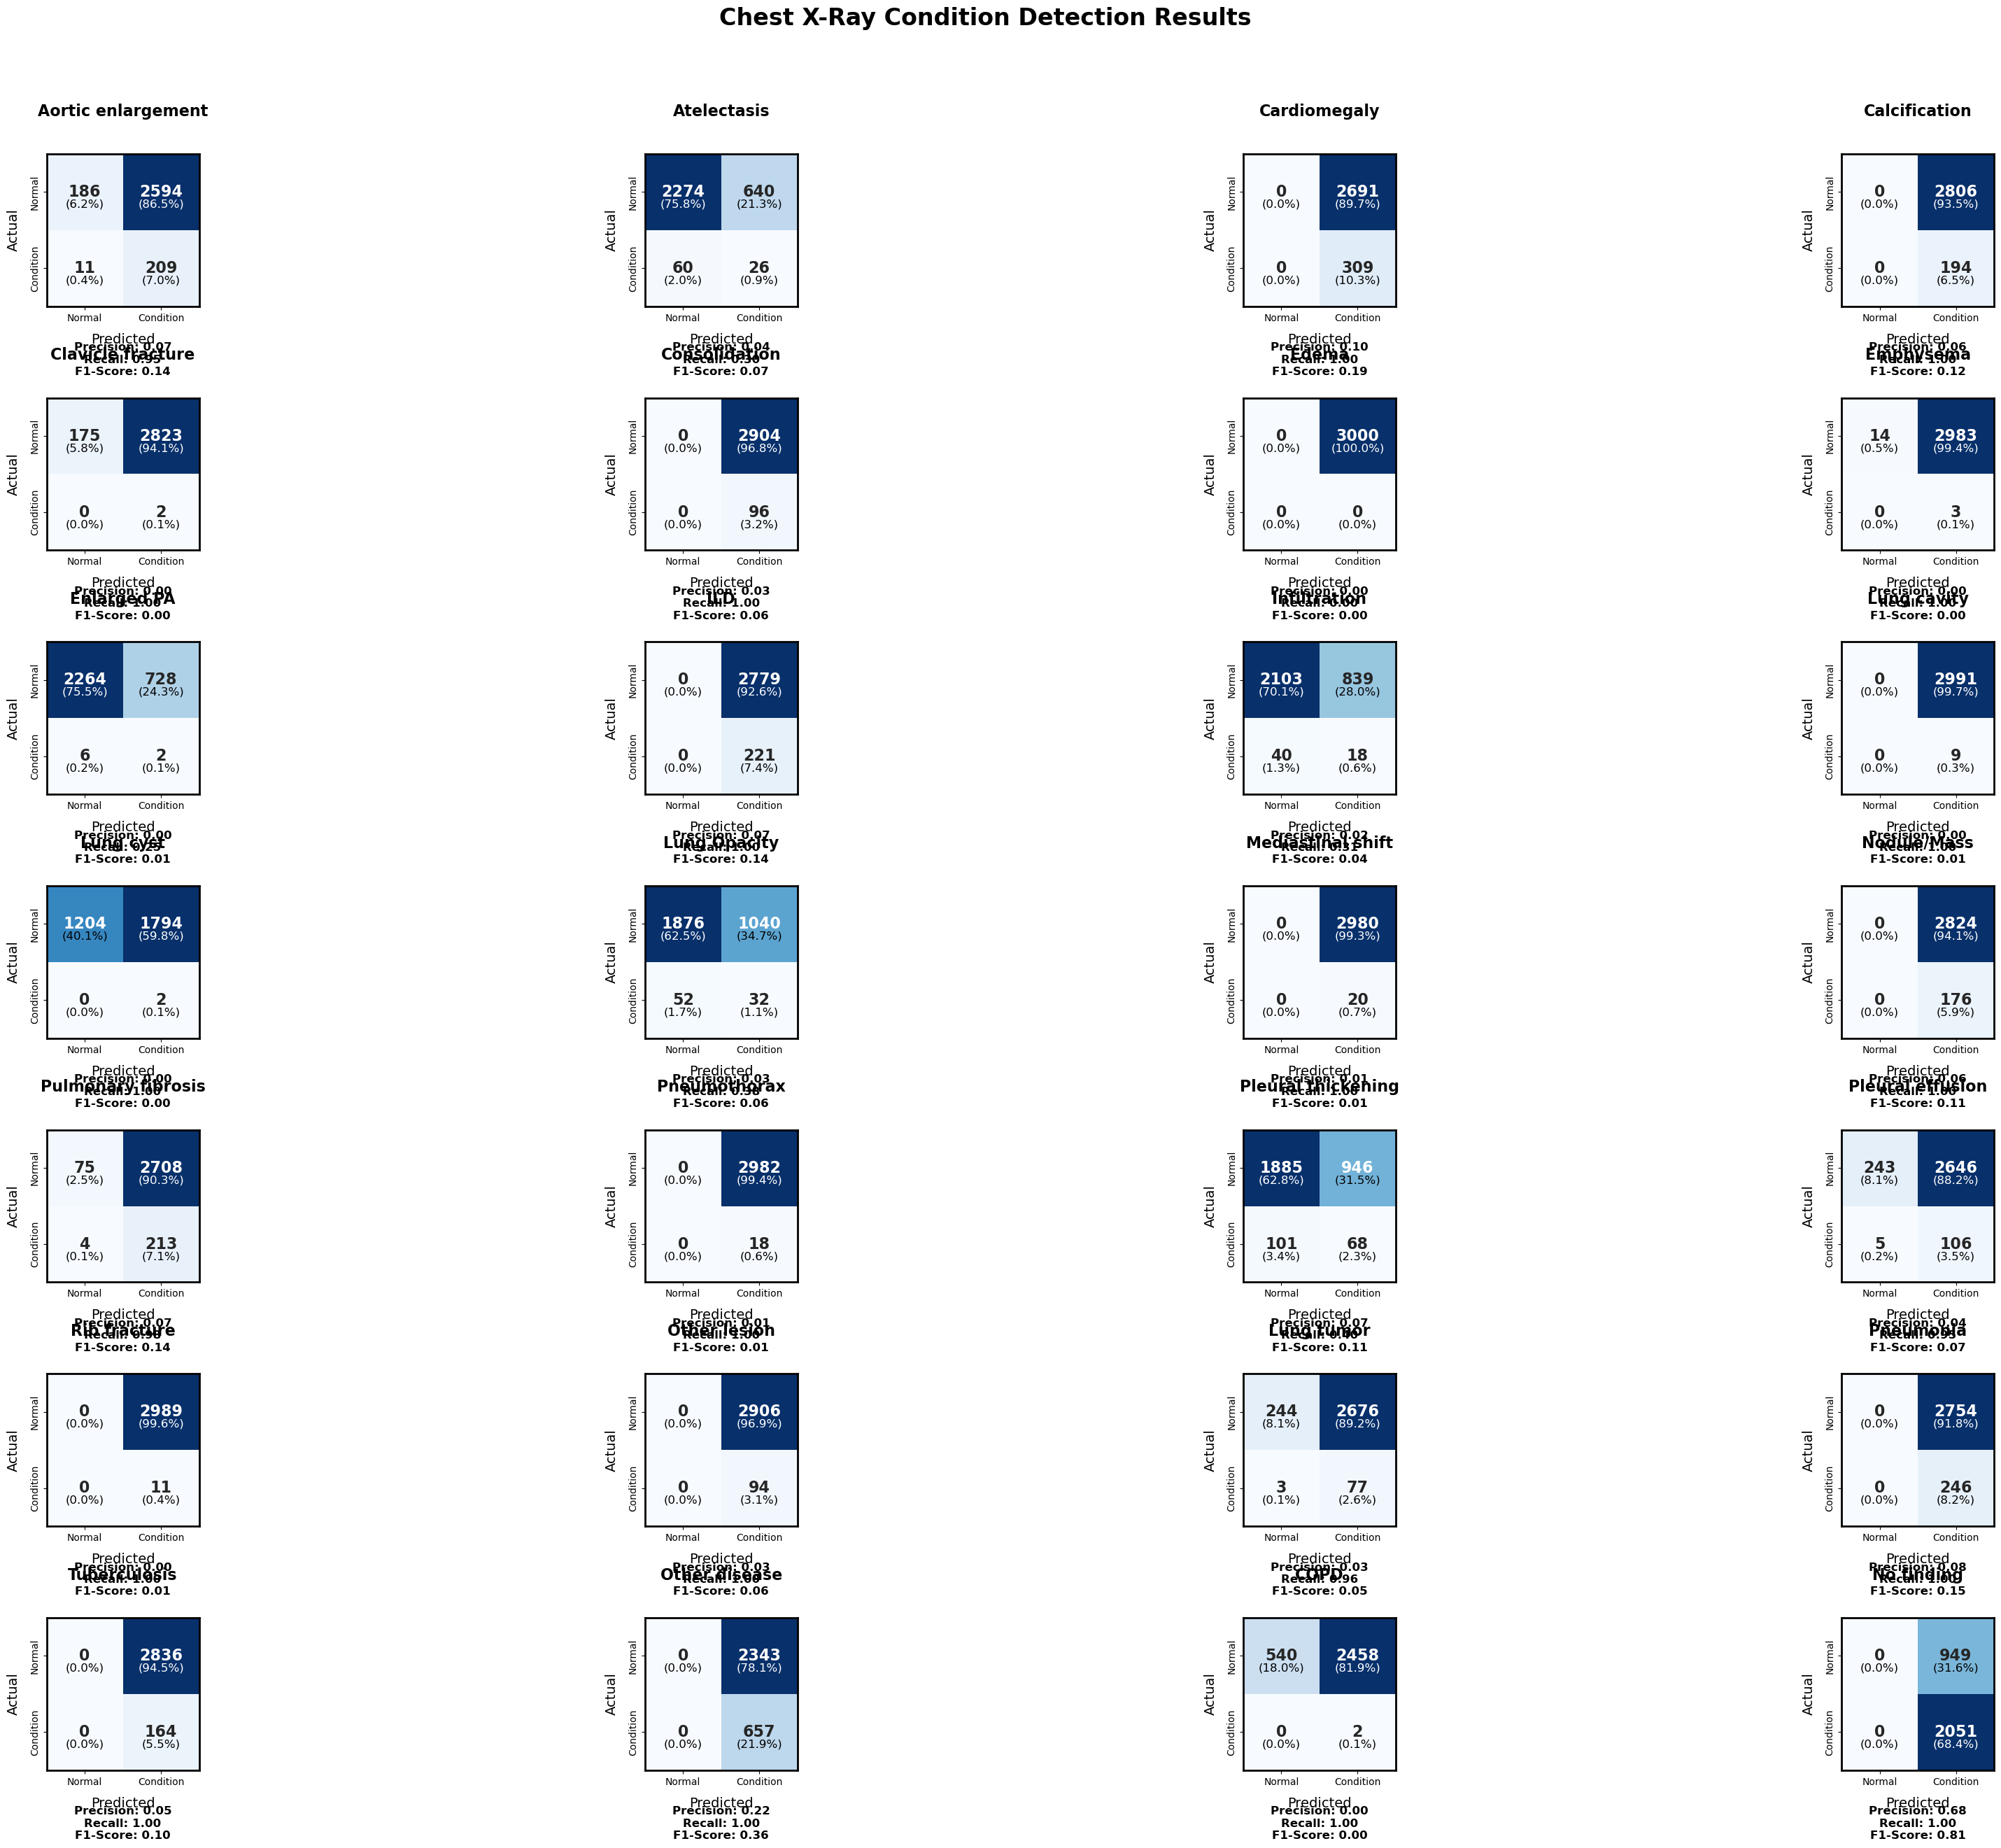

In [9]:
# Create the clearer visualization
fig = plot_simplified_confusion_matrices(test_pred, test_true, cxr_labels)

# Print the detailed summary
print_detailed_summary(test_pred, test_true, cxr_labels)

# Show the plot
plt.show()

In [ ]:
print_detailed_summary(test_pred, test_true, cxr_labels)


Optimal metrics for No Finding:
Threshold: 0.000
F1-Score: 0.221
Precision: 0.124
Recall: 1.000

Optimal metrics for Enlarged Cardiomediastinum:
Threshold: 0.500
F1-Score: 0.718
Precision: 0.909
Recall: 0.593

Optimal metrics for Cardiomegaly:
Threshold: 0.500
F1-Score: 0.710
Precision: 0.773
Recall: 0.656

Optimal metrics for Lung Opacity:
Threshold: 0.500
F1-Score: 0.824
Precision: 0.758
Recall: 0.902

Optimal metrics for Lung Lesion:
Threshold: 0.500
F1-Score: 0.039
Precision: 0.020
Recall: 0.875

Optimal metrics for Edema:
Threshold: 0.500
F1-Score: 0.571
Precision: 0.419
Recall: 0.897

Optimal metrics for Consolidation:
Threshold: 0.500
F1-Score: 0.233
Precision: 0.133
Recall: 0.931

Optimal metrics for Pneumonia:
Threshold: 0.510
F1-Score: 0.286
Precision: 0.300
Recall: 0.273

Optimal metrics for Atelectasis:
Threshold: 0.500
F1-Score: 0.617
Precision: 0.487
Recall: 0.843

Optimal metrics for Pneumothorax:
Threshold: 0.000
F1-Score: 0.035
Precision: 0.018
Recall: 1.000

Optimal 